In [1]:
#!pip install git+https://gitlab.wikimedia.org/repos/research/research-common.git

/home/fab/.conda/envs/2023-03-16T14.06.06_fab/bin/python


In [ ]:
from research_common.spark import create_yarn_spark_session
from pyspark.sql import functions as F

conf =  {
    "spark.dynamicAllocation.maxExecutors": 49,
    "spark.executor.cores": 4,
    "spark.sql.shuffle.partitions": 999,
    "spark.executor.memory": "14g",
    "spark.executor.memoryOverhead": "2g", 
}

spark = create_yarn_spark_session(
    app_id='diffing',
    extra_config=conf,
    gitlab_project='repos/research/wikidiff',
    version='diff_pipeline'
)


# Read diff dataset

In [2]:
mw_snapshot = "2023-02"
wiki_db = 'kowiki'
# wiki_db = 'enwiki'

diff_df = (spark.read.parquet("/wmf/data/research/diff/")
    .where(f"snapshot='{mw_snapshot}'")
    .where(f"wiki_db='{wiki_db}'")
)

diff_df.printSchema()

23/04/03 15:34:53 WARN SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 262144000 bytes). This may impact query planning performance.


root
 |-- page_id: long (nullable = true)
 |-- page_namespace: integer (nullable = true)
 |-- page_title: string (nullable = true)
 |-- page_redirect_title: string (nullable = true)
 |-- page_restrictions: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- user_id: long (nullable = true)
 |-- user_text: string (nullable = true)
 |-- revision_id: long (nullable = true)
 |-- revision_parent_id: long (nullable = true)
 |-- revision_timestamp: string (nullable = true)
 |-- revision_minor_edit: boolean (nullable = true)
 |-- revision_comment: string (nullable = true)
 |-- revision_text_bytes: long (nullable = true)
 |-- revision_text_sha1: string (nullable = true)
 |-- revision_text: string (nullable = true)
 |-- revision_content_model: string (nullable = true)
 |-- revision_content_format: string (nullable = true)
 |-- diff: string (nullable = true)
 |-- snapshot: string (nullable = true)
 |-- wiki_db: string (nullable = true)



In [3]:
from wikidiff.diff import apply_diff

current_prev_df = (diff_df
    .withColumn('prev_text', apply_diff('revision_text', 'diff'))
    .select('revision_id', F.col('revision_text').alias('curr_text'), 'prev_text')
)

current_prev_df.printSchema()


root
 |-- revision_id: long (nullable = true)
 |-- curr_text: string (nullable = true)
 |-- prev_text: string (nullable = true)



In [4]:
current_prev_df.show()

+-----------+-----------------------------+-----------------------------+
|revision_id|                    curr_text|                    prev_text|
+-----------+-----------------------------+-----------------------------+
|   19641047| {{과학자 정보
| 이름 = 존...| {{과학자 정보
| 이름 = 존...|
|   20351337| {{다른 사람}}
{{음악가 정...| {{다른 사람}}
{{음악가 정...|
|    9938905|  {{영화인 정보
| 이름    ...|  {{영화인 정보
| 이름    ...|
|   32603030|{{위키데이터 속성 추적}}
{...|{{위키데이터 속성 추적}}
{...|
|   17922558|'''대한민국의 기념일'''은 ...|'''대한민국의 기념일'''은 ...|
|   29198249|'''애슈타 전파 납치 사건''...|'''애슈타 전파 납치 사건''...|
|   19003266|   {{정리 필요|날짜=2017-0...|   {{정리 필요|날짜=2017-0...|
|   26531266|{{음악가 정보
|이름 = 지민...|{{음악가 정보
|이름 = 지민...|
|   29856050|{{축구 선수 정보
|이름= 고...|{{축구 선수 정보
|이름= 고...|
|   34361831|{{위키데이터 속성 추적}}
{...|{{위키데이터 속성 추적}}
{...|
|   12118461|   {{인물 정보
|이름     =...|   {{인물 정보
|이름     =...|
|   13810999|      '''오경아'''(1967.10...|      '''오경아'''(1967.10...|
|   32656847|{{위키데이터 속성 추적}}
{...|{{위키데이터 속성 추적}}
{...|
|    8700309|{{축구 

### Example using both revision texts

In [5]:
from pyspark.sql import functions as F

kb_bucket = 10

@F.udf(returnType='int')
def kb_diff(curr_text, prev_text):
    if curr_text and prev_text:
        prev_text_kb = len(prev_text.encode('utf-8'))/1024
        curr_text_kb = len(curr_text.encode('utf-8'))/1024
        return int((prev_text_kb-curr_text_kb) / kb_bucket)
    else:
        return None


hist = (current_prev_df
    .withColumn('kb_diff', kb_diff("curr_text", "prev_text"))
    .groupby('kb_diff')
    .count()
    .orderBy(F.col('kb_diff').asc())
).toPandas()

hist['kb_diff'] *= kb_bucket



In [13]:
hist[115:120]

kb_diff     count
115    -10.0     18303
116      0.0  23075859
117     10.0     13487
118     20.0      4669
119     30.0      2414

<AxesSubplot: xlabel='size difference between current and previous revision text (in KB)'>

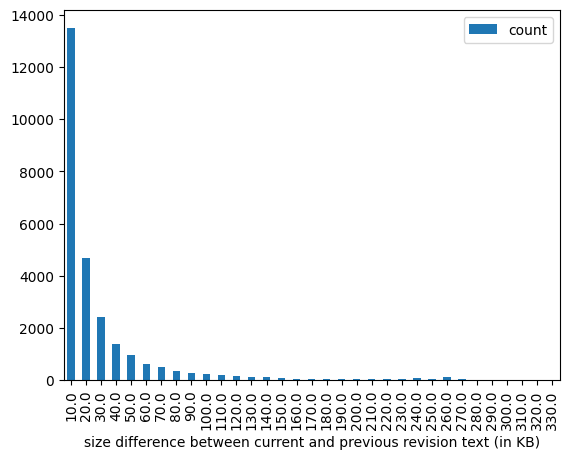

In [14]:
hist[117:150].plot.bar('kb_diff','count',xlabel='size difference between current and previous revision text (in KB)') 